In [1]:
import pandas as pd
import numpy as np
import os



In [2]:
# Read in the data
path = 'Data/'
files = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.csv')]

df = pd.concat((pd.read_csv(file) for file in files), ignore_index=True)
df.head()

,noOfUnits,tenure,marketSegment,typeOfSale,district,nettPrice,x,propertyType,price,project,y,floorRange,area,street,contractDate,typeOfArea
0,1,Freehold,RCR,3,5,NaN,20914.198897,Strata Terrace,1880000,LANDED HOUSING DEVELOPMENT,30589.107079,-,186.0,NEO PEE TECK LANE,321,Strata
1,1,Freehold,RCR,3,5,NaN,20914.198897,Terrace,4600000,LANDED HOUSING DEVELOPMENT,30589.107079,-,257.0,NEO PEE TECK LANE,522,Land
2,1,Freehold,RCR,3,5,NaN,NaN,Semi-detached,5200000,LANDED HOUSING DEVELOPMENT,NaN,-,308.0,ZEHNDER ROAD,921,Land
3,1,Freehold,RCR,3,5,NaN,NaN,Semi-detached,5188888,LANDED HOUSING DEVELOPMENT,NaN,-,228.4,ZEHNDER ROAD,724,Land
4,1,99 yrs lease commencing from 2024,CCR,1,7,NaN,NaN,Apartment,2065000,AUREA,NaN,21-25,66.0,BEACH ROAD,925,Strata


In [3]:
# Map contractDate to Month and Year
df = df.drop_duplicates()
df['contractYear'] = df['contractDate'].apply(lambda x: x % 100 + 2000)
df['contractMonth'] = df['contractDate'].apply(lambda x: x // 100)

# Separate tenure into tenure duration and start year
df['tenure'] = df['tenure'].str.lower()     # Convert to lowercase for consistency
df['tenureDuration'] = df['tenure'].apply(lambda x: np.inf if 'freehold' in str(x) else int(x.split(' ')[0]) if isinstance(x, str) and len(x.split(' ')) > 1 else np.nan)      # If 'freehold' then 0, if NaN then NaN
df['tenureStartYear'] = df['tenure'].apply(lambda x: int(x.split(' ')[-1]) if isinstance(x, str) and len(x.split(' ')) > 3 else np.nan)     # If 'freehold' or '99 years lease' then nan
df['tenureRemaining'] = df.apply(lambda x: np.inf if 'freehold' in str(x['tenure']) else (x['tenureDuration'] - (x['contractYear'] - x['tenureStartYear'])) if not pd.isna(x['tenureStartYear']) else np.nan, axis=1)

# Map propertyType to numerical values
print(df['propertyType'].unique())
Mapping_PropertyType = {
    'Strata Terrace': 1,
    'Terrace': 2,
    'Semi-detached': 3,
    'Apartment': 4,
    'Condominium': 5,
    'Deteched': 6,
    'Strata Semi-detached': 7,
    'Strata Deteched': 8,
    'Executive Condominium': 9}
df['propertyType'] = df['propertyType'].map(Mapping_PropertyType)

# Map floorRange to numerical values
df['floorRange'] = df['floorRange'].apply(lambda x: -int(x.split('-')[-1].replace('B','')) if isinstance(x,str) and 'B' in x and x.strip() not in ['-',''] else int(x.split('-')[-1]) if isinstance(x,str) and len(x.split('-')[-1])==2 and x.strip() not in ['-',''] else np.nan)
 
# Map typeOfArea to numerical values
df['typeOfArea'] = df['typeOfArea'].apply(lambda x: 1 if isinstance(x,str) and x == 'Strata' else 2 if isinstance(x,str) and x == 'Land' else x)

# Drop nettPrice
df = df.drop(columns=['nettPrice', 'tenure', 'contractDate'])

df_copy = df.copy()
df.head()

['Strata Terrace' 'Terrace' 'Semi-detached' 'Apartment' 'Condominium'
 'Detached' 'Strata Semi-detached' 'Strata Detached'
 'Executive Condominium']


,noOfUnits,marketSegment,typeOfSale,district,x,propertyType,price,project,y,floorRange,area,street,typeOfArea,contractYear,contractMonth,tenureDuration,tenureStartYear,tenureRemaining
0,1,RCR,3,5,20914.198897,1.0,1880000,LANDED HOUSING DEVELOPMENT,30589.107079,NaN,186.0,NEO PEE TECK LANE,1,2021,3,inf,NaN,inf
1,1,RCR,3,5,20914.198897,2.0,4600000,LANDED HOUSING DEVELOPMENT,30589.107079,NaN,257.0,NEO PEE TECK LANE,2,2022,5,inf,NaN,inf
2,1,RCR,3,5,NaN,3.0,5200000,LANDED HOUSING DEVELOPMENT,NaN,NaN,308.0,ZEHNDER ROAD,2,2021,9,inf,NaN,inf
3,1,RCR,3,5,NaN,3.0,5188888,LANDED HOUSING DEVELOPMENT,NaN,NaN,228.4,ZEHNDER ROAD,2,2024,7,inf,NaN,inf
4,1,CCR,1,7,NaN,4.0,2065000,AUREA,NaN,25.0,66.0,BEACH ROAD,1,2025,9,99.0,2024.0,98.0


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error

In [5]:
df['transactionDate'] = df['contractYear'] + (df['contractMonth'] - 1) / 12

In [6]:
sorted(df['transactionDate'].unique())

[2020.6666666666667,
 2020.75,
 2020.8333333333333,
 2020.9166666666667,
 2021.0,
 2021.0833333333333,
 2021.1666666666667,
 2021.25,
 2021.3333333333333,
 2021.4166666666667,
 2021.5,
 2021.5833333333333,
 2021.6666666666667,
 2021.75,
 2021.8333333333333,
 2021.9166666666667,
 2022.0,
 2022.0833333333333,
 2022.1666666666667,
 2022.25,
 2022.3333333333333,
 2022.4166666666667,
 2022.5,
 2022.5833333333333,
 2022.6666666666667,
 2022.75,
 2022.8333333333333,
 2022.9166666666667,
 2023.0,
 2023.0833333333333,
 2023.1666666666667,
 2023.25,
 2023.3333333333333,
 2023.4166666666667,
 2023.5,
 2023.5833333333333,
 2023.6666666666667,
 2023.75,
 2023.8333333333333,
 2023.9166666666667,
 2024.0,
 2024.0833333333333,
 2024.1666666666667,
 2024.25,
 2024.3333333333333,
 2024.4166666666667,
 2024.5,
 2024.5833333333333,
 2024.6666666666667,
 2024.75,
 2024.8333333333333,
 2024.9166666666667,
 2025.0,
 2025.0833333333333,
 2025.1666666666667,
 2025.25,
 2025.3333333333333,
 2025.4166666666667,


In [7]:
df.drop(columns= ['contractYear', 'contractMonth'])

,noOfUnits,marketSegment,typeOfSale,district,x,propertyType,price,project,y,floorRange,area,street,typeOfArea,tenureDuration,tenureStartYear,tenureRemaining,transactionDate
0,1,RCR,3,5,20914.198897,1.0,1880000,LANDED HOUSING DEVELOPMENT,30589.107079,NaN,186.0,NEO PEE TECK LANE,1,inf,NaN,inf,2021.166667
1,1,RCR,3,5,20914.198897,2.0,4600000,LANDED HOUSING DEVELOPMENT,30589.107079,NaN,257.0,NEO PEE TECK LANE,2,inf,NaN,inf,2022.333333
2,1,RCR,3,5,NaN,3.0,5200000,LANDED HOUSING DEVELOPMENT,NaN,NaN,308.0,ZEHNDER ROAD,2,inf,NaN,inf,2021.666667
3,1,RCR,3,5,NaN,3.0,5188888,LANDED HOUSING DEVELOPMENT,NaN,NaN,228.4,ZEHNDER ROAD,2,inf,NaN,inf,2024.500000
4,1,CCR,1,7,NaN,4.0,2065000,AUREA,NaN,25.0,66.0,BEACH ROAD,1,99.0,2024.0,98.0,2025.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143216,1,OCR,2,28,32836.647100,3.0,4150000,GERALD MUGLISTON ESTATE,40981.743260,NaN,204.0,GERALD CRESCENT,2,999.0,1879.0,857.0,2021.250000
143217,1,OCR,2,28,32836.647100,3.0,4150000,GERALD MUGLISTON ESTATE,40981.743260,NaN,204.0,GERALD CRESCENT,2,999.0,1879.0,857.0,2021.583333
143218,1,OCR,3,28,32836.647100,NaN,4700000,GERALD MUGLISTON ESTATE,40981.743260,NaN,434.0,GERALD CRESCENT,2,999.0,1879.0,855.0,2023.416667
143219,1,OCR,3,28,32836.647100,3.0,2600000,GERALD MUGLISTON ESTATE,40981.743260,NaN,208.2,GERALD CRESCENT,2,99.0,1997.0,72.0,2024.166667


In [8]:
df.dropna(inplace=True)
X = df.drop('price', axis=1)
y = df['price']

X = pd.get_dummies(X)
print(X.shape, y.shape)

(78286, 1129) (78286,)


In [9]:
# split train test based on transaction date less than 2024.66
X_train = X[X['transactionDate'] < 2024.66]
y_train = y[X['transactionDate'] < 2024.66]
X_test = X[X['transactionDate'] >= 2024.66]
y_test = y[X['transactionDate'] >= 2024.66]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(64691, 1129) (64691,) (13595, 1129) (13595,)


In [10]:
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [11]:
# Make predictions
y_pred = model.predict(X_test)

# Combine actual and predicted values
comparison = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

pd.set_option('display.float_format', '{:.0f}'.format)
print(comparison.head(20))  # Show first 10 rows

     Actual  Predicted
0   9000000   11487468
1   3800000    4281794
2   3298000    4010873
3   3500000    4141966
4   3051000    4131479
5   3100000    3476607
6   2472000    2412137
7   1860000    1981189
8   2510000    2470008
9   1836000    1891859
10  1910000    2042948
11  1868888    1945656
12  1800000    1922976
13  2700000    2651052
14  2520000    2395871
15  1840000    1922976
16  1854000    1980846
17  2930000    2771271
18  1990000    2013670
19  2630000    2588132


In [12]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}, R²: {r2:.5f}', f'RMSE: {rmse:.2f}', f'MAE: {mae:.2f}')

MSE: 1602523984965.50, R²: -1.34016 RMSE: 1265908.36 MAE: 383466.44


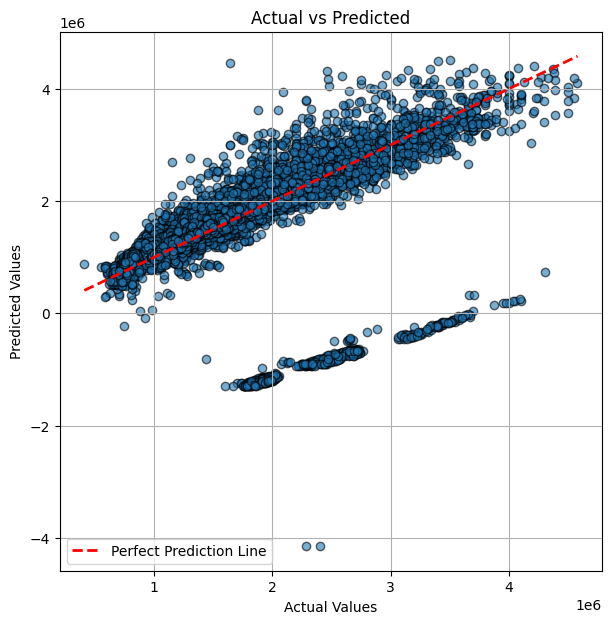

In [13]:
import matplotlib.pyplot as plt
# remove outliers for better visualization
mask = (y_test < y_test.quantile(0.99)) & (y_pred < y_test.quantile(0.99))
plt.figure(figsize=(7, 7))
plt.scatter(y_test[mask], y_pred[mask], alpha=0.6, edgecolors='k')
plt.plot([y_test[mask].min(), y_test[mask].max()],
         [y_test[mask].min(), y_test[mask].max()],
         'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

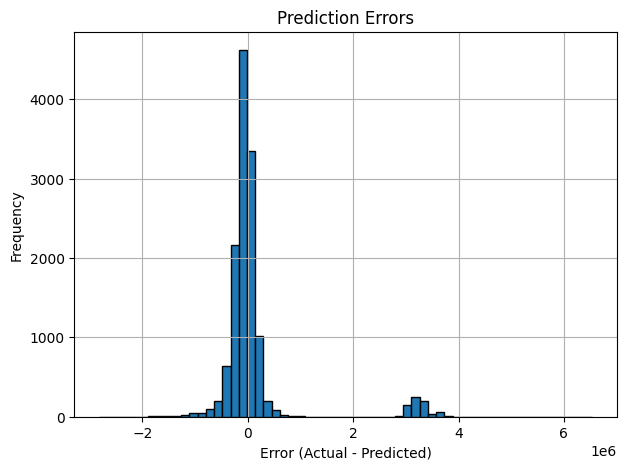

In [14]:
plt.figure(figsize=(7, 5))
plt.hist(y_test[mask] - y_pred[mask], bins=60, edgecolor='black')
plt.title("Prediction Errors")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [15]:
# Drop project name and street from df
df_new = df.drop(columns=['project', 'street'])
X_new = df_new.drop('price', axis=1)
y_new = df_new['price']

X_new = pd.get_dummies(X_new)
X_train_new = X_new[X_new['transactionDate'] < 2024.66]
y_train_new = y_new[X_new['transactionDate'] < 2024.66]
X_test_new = X_new[X_new['transactionDate'] >= 2024.66]
y_test_new = y_new[X_new['transactionDate'] >= 2024.66]
print(X_train_new.shape, y_train_new.shape, X_test_new.shape, y_test_new.shape)

(64691, 18) (64691,) (13595, 18) (13595,)


In [16]:
# Run OLS regression again without project and street
model_new = LinearRegression()
model_new.fit(X_train_new, y_train_new)
y_pred_new = model_new.predict(X_test_new)
# Evaluate the new model
mse_new = mean_squared_error(y_test_new, y_pred_new)
rmse_new = np.sqrt(mse_new)
mae_new = mean_absolute_error(y_test_new, y_pred_new)
r2_new = r2_score(y_test_new, y_pred_new)
print(f'New MSE: {mse_new:.2f}, New R²: {r2_new:.5f}', f'New RMSE: {rmse_new:.2f}', f'New MAE: {mae_new:.2f}')


New MSE: 202596245882.50, New R²: 0.70415 New RMSE: 450106.93 New MAE: 294056.99


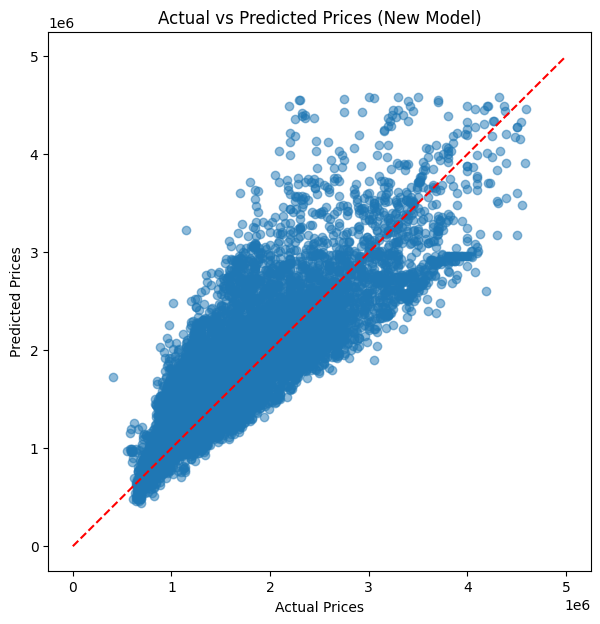

In [17]:
#Plotting Actual vs Predicted for new model
mask = (y_test_new < y_test_new.quantile(0.99)) & (y_pred_new < y_test_new.quantile(0.99))
plt.figure(figsize=(7, 7))
plt.scatter(y_test_new[mask], y_pred_new[mask], alpha=0.5)
plt.plot([0, 5000000], [0, 5000000], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (New Model)')
plt.show()

OLS Improves significantly when we remove street name and project name as they were causing the overfitting.

In [18]:
# Running Lasso Regression
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=1000)  # You can adjust alpha for regularization strength
lasso_model.fit(X_train_new, y_train_new)
y_pred_lasso = lasso_model.predict(X_test_new)
# Evaluate the Lasso model
mse_lasso = mean_squared_error(y_test_new, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
mae_lasso = mean_absolute_error(y_test_new, y_pred_lasso)
r2_lasso = r2_score(y_test_new, y_pred_lasso)
print(f'Lasso MSE: {mse_lasso:.2f}, Lasso R²: {r2_lasso:.5f}', f'Lasso RMSE: {rmse_lasso:.2f}', f'Lasso MAE: {mae_lasso:.2f}')



Lasso MSE: 201890190853.32, Lasso R²: 0.70518 Lasso RMSE: 449321.92 Lasso MAE: 293699.73


/Users/adityakumarpugalia/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.669e+14, tolerance: 9.923e+13
  model = cd_fast.enet_coordinate_descent(


Text(0.5, 1.0, 'Actual vs Predicted Prices (New Model)')

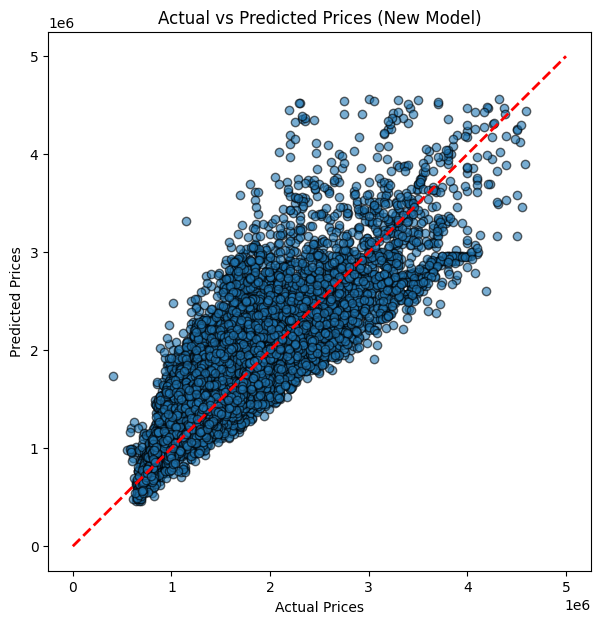

In [19]:
#Plotting Actual vs Predicted for new model
plt.figure(figsize=(7, 7))
plt.scatter(y_test_new[mask], y_pred_lasso[mask], alpha=0.6, edgecolors='k')
plt.plot([0, 5000000],
         [0, 5000000],
         'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (New Model)')

In [34]:
# lagged variables and interaction terms can be explored further to improve model performance
df_time = df.copy()
df_time = df_time.sort_values(by='transactionDate')
df_time['psm'] = df_time['price'] / df_time['area']
df_time["project_price_psm"] = df_time.groupby(['project', 'contractYear'])['psm'].transform('mean')
print(df_time.shape)
df_time.head()

(78286, 21)


,noOfUnits,marketSegment,typeOfSale,district,x,propertyType,price,project,y,floorRange,...,street,typeOfArea,contractYear,contractMonth,tenureDuration,tenureStartYear,tenureRemaining,transactionDate,psm,project_price_psm
80677,1,OCR,1,19,32059,4,1598300,THE GARDEN RESIDENCES,38662,10,...,SERANGOON NORTH VIEW,1,2020,9,99,2017,96,2021,19027,17279
58683,1,OCR,1,18,40757,5,1712000,TREASURE AT TAMPINES,36359,15,...,TAMPINES LANE,1,2020,9,99,2018,97,2021,14508,15020
81018,1,OCR,1,19,35168,9,1005400,PIERMONT GRAND,43541,15,...,SUMANG WALK,1,2020,9,99,2018,97,2021,12890,12159
129509,1,OCR,3,23,19415,9,1250000,THE DEW,36487,10,...,BUKIT BATOK STREET 21,1,2020,9,99,2000,79,2021,9690,8617
81028,1,OCR,1,19,35168,9,906390,PIERMONT GRAND,43541,5,...,SUMANG WALK,1,2020,9,99,2018,97,2021,11620,12159


In [ ]:
df_proj_year = (
    df_time.groupby(['project','contractYear'])['project_price_psm']
    .mean()
    .reset_index()
)
df_proj_year.head(10)


,project,contractYear,project_price_psm
0,1 CANBERRA,2020,9402
1,1 CANBERRA,2021,10065
2,1 CANBERRA,2022,11257
3,1 CANBERRA,2023,12553
4,1 CANBERRA,2024,13026
5,1 CANBERRA,2025,13668
6,19 NASSIM,2021,40373
7,19 NASSIM,2023,37927
8,19 NASSIM,2024,36508
9,19 NASSIM,2025,36336


In [37]:
df_proj_year = df_proj_year.sort_values(['project','contractYear'])
df_proj_year['lagged_price_psm'] = df_proj_year.groupby('project')['project_price_psm'].shift(1)
df_proj_year['lagged_price_psm_2'] = df_proj_year.groupby('project')['project_price_psm'].shift(2)
df_proj_year.head(10)

,project,contractYear,project_price_psm,lagged_price_psm,lagged_price_psm_2
0,1 CANBERRA,2020,9402,NaN,NaN
1,1 CANBERRA,2021,10065,9402,NaN
2,1 CANBERRA,2022,11257,10065,9402
3,1 CANBERRA,2023,12553,11257,10065
4,1 CANBERRA,2024,13026,12553,11257
5,1 CANBERRA,2025,13668,13026,12553
6,19 NASSIM,2021,40373,NaN,NaN
7,19 NASSIM,2023,37927,40373,NaN
8,19 NASSIM,2024,36508,37927,40373
9,19 NASSIM,2025,36336,36508,37927


In [38]:
df_time = df_time.merge(
    df_proj_year[['project','contractYear','lagged_price_psm', 'lagged_price_psm_2']],
    on=['project','contractYear'],
    how='left'
)
df_time.head(10)

,noOfUnits,marketSegment,typeOfSale,district,x,propertyType,price,project,y,floorRange,...,contractYear,contractMonth,tenureDuration,tenureStartYear,tenureRemaining,transactionDate,psm,project_price_psm,lagged_price_psm,lagged_price_psm_2
0,1,OCR,1,19,32059,4,1598300,THE GARDEN RESIDENCES,38662,10,...,2020,9,99,2017,96,2021,19027,17279,NaN,NaN
1,1,OCR,1,18,40757,5,1712000,TREASURE AT TAMPINES,36359,15,...,2020,9,99,2018,97,2021,14508,15020,NaN,NaN
2,1,OCR,1,19,35168,9,1005400,PIERMONT GRAND,43541,15,...,2020,9,99,2018,97,2021,12890,12159,NaN,NaN
3,1,OCR,3,23,19415,9,1250000,THE DEW,36487,10,...,2020,9,99,2000,79,2021,9690,8617,NaN,NaN
4,1,OCR,1,19,35168,9,906390,PIERMONT GRAND,43541,5,...,2020,9,99,2018,97,2021,11620,12159,NaN,NaN
5,1,OCR,1,19,35168,9,1007900,PIERMONT GRAND,43541,10,...,2020,9,99,2018,97,2021,12443,12159,NaN,NaN
6,1,RCR,1,14,35713,4,1240000,PARC ESTA,33394,20,...,2020,9,99,2018,97,2021,19375,18477,NaN,NaN
7,1,OCR,1,18,40757,5,962000,TREASURE AT TAMPINES,36359,5,...,2020,9,99,2018,97,2021,15270,15020,NaN,NaN
8,1,OCR,3,27,27018,5,696000,EUPHONY GARDENS,45271,5,...,2020,9,99,1998,77,2021,7909,7330,NaN,NaN
9,1,OCR,1,27,27451,9,1031000,PARC CANBERRA,47627,10,...,2020,9,99,2018,97,2021,11716,11878,NaN,NaN


In [ ]:
df_time = df_time.drop(columns=['psm', 'project_price_psm', 'street', 'project'])

In [45]:

df_time.shape

(78286, 19)

In [46]:
df_time.dropna(inplace=True)
X_time = df_time.drop('price', axis=1)
y_time = df_time['price']
X_time = pd.get_dummies(X_time)
print(X_time.shape, y_time.shape)

X_time_train = X_time[X_time['transactionDate'] < 2024.66]
y_time_train = y_time[X_time['transactionDate'] < 2024.66]
X_time_test = X_time[X_time['transactionDate'] >= 2024.66]
y_time_test = y_time[X_time['transactionDate'] >= 2024.66]
print(X_time_train.shape, y_time_train.shape, X_time_test.shape, y_time_test.shape)


(43339, 20) (43339,)
(30674, 20) (30674,) (12665, 20) (12665,)


In [47]:
# Train the model
model_time = LinearRegression()
model_time.fit(X_time_train, y_time_train)
y_time_pred = model_time.predict(X_time_test)
# Evaluate the model
mse_time = mean_squared_error(y_time_test, y_time_pred)
rmse_time = np.sqrt(mse_time)
mae_time = mean_absolute_error(y_time_test, y_time_pred)
r2_time = r2_score(y_time_test, y_time_pred)
print(f'Time MSE: {mse_time:.2f}, Time R²: {r2_time:.5f}', f'Time RMSE: {rmse_time:.2f}', f'Time MAE: {mae_time:.2f}')


Time MSE: 97815150617.23, Time R²: 0.85236 Time RMSE: 312754.14 Time MAE: 180400.76


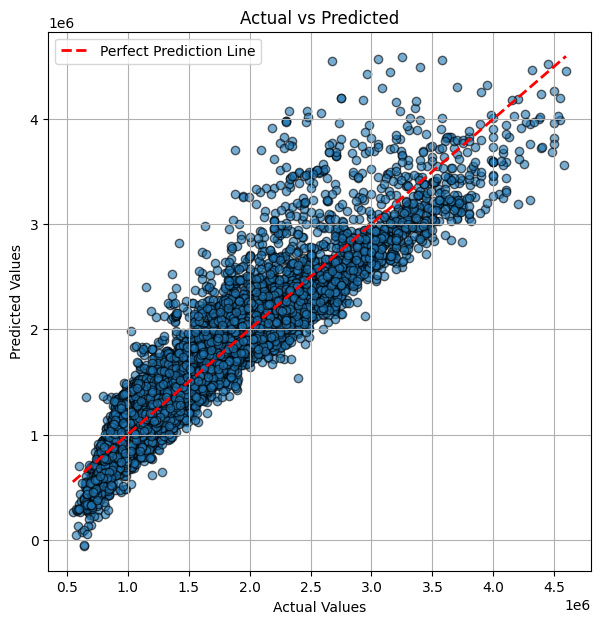

In [48]:
#plotting Actual vs Predicted for new model
mask = (y_time_test < y_time_test.quantile(0.99)) & (
    y_time_pred < y_time_test.quantile(0.99)
)

plt.figure(figsize=(7, 7))
plt.scatter(y_time_test[mask], y_time_pred[mask], alpha=0.6
, edgecolors='k')
plt.plot([y_time_test[mask].min(), y_time_test[mask].max()],
            [y_time_test[mask].min(), y_time_test[mask].max()],         
            'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)

In [50]:
district_df = df.copy()
district_df['ppsqm'] = district_df['price'] / district_df['area']

df_district_year = (
    district_df.groupby(['district','contractYear'])['ppsqm']
    .mean()
    .reset_index()
)
df_district_year.head(10)

,district,contractYear,ppsqm
0,1,2020,21524
1,1,2021,22559
2,1,2022,22252
3,1,2023,21656
4,1,2024,21516
5,1,2025,21028
6,2,2020,20641
7,2,2021,23656
8,2,2022,23572
9,2,2023,23100


In [ ]:
#forecasting on future ppsqm for each district

